## Retrieve the dataset online or locally
Ref: Center for systems science and engineering (CSSE) at Johns Hopkins University (JHU) time series data set for COVID-19 cases. 2020; (Online) Available at: [https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series]

In [1]:
import os
import numpy as np
from six.moves import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
DATA_PATH = "data_covid"
TABLE = ["time_series_covid19_confirmed_global.csv", "time_series_covid19_deaths_global.csv", "time_series_covid19_recovered_global.csv "]


#Download the .csv's locally
def fetch_data(download_root = DOWNLOAD_ROOT, data_path = DATA_PATH, table=TABLE[0]):
    data_url = download_root + table
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
        
    name = table.split(".")[0]
    csv_path = os.path.join(data_path, (name+".csv"))
    urllib.request.urlretrieve(data_url, csv_path)
    
#just load the locals .csv's and if they're not in the specified directory, gets from url source
def load_housing_data(data_path=DATA_PATH, download_root = DOWNLOAD_ROOT, table=TABLE[0]):
    name = table.split(".")[0]
    csv_path = os.path.join(data_path, (name+".csv"))
    
    if not os.path.exists(csv_path):
        print("getting "+ table + " from url source...")
        csv_url = os.path.join(download_root, table)
        return pd.read_csv(csv_url)
    return pd.read_csv(csv_path)

def df_country(country,df,lim_date=None):
    if (lim_date is not None): #if the user inputs a limit date
        df = df.loc[:,:lim_date]
    df_country = df.loc[df["Country/Region"]==country]
    if len(df_country.index)>1: #if country has different domains, take the "main" one
        df_country = df_country[df_country["Province/State"].isnull()]
#     print(df.columns)
    df_country = (df_country.to_numpy())[0][4:] #transforms into array
    return df_country

def retrieve_cdr(country,lim_date=None): #confirmed, death, recovered retrieve c,d,r as arrays
    c,d,r =  [load_housing_data(table=i) for i in TABLE]
    
    return df_country(country,c,lim_date),df_country(country,d,lim_date),df_country(country,r,lim_date)

        

In [2]:
#Run if you want to download the data sets
# [fetch_data(table=i) for i in TABLE]

## Exploration of data-set

In [3]:
#countries
df = load_housing_data()
df["Country/Region"]

0             Afghanistan
1                 Albania
2                 Algeria
3                 Andorra
4                  Angola
              ...        
264    West Bank and Gaza
265        Western Sahara
266                 Yemen
267                Zambia
268              Zimbabwe
Name: Country/Region, Length: 269, dtype: object

In [4]:
#dates
dates = df.columns[4:]
print("first data from ", dates[0])
print("last data from ", dates[-1])

first data from  1/22/20
last data from  11/18/20


In [5]:
#size of data-set
print("number of points considered: ", len(dates))

number of points considered:  302


## Mathematical Justification

When there is no infection $S \approx N$ and I + R = 0\
$\frac{dI}{dt} = \beta SI - \nu I$ then becomes\
$\frac{dI}{dt} \sim I(\beta - \nu)$\
integrating it we have\
$I(t) = I_{0}e^{(\beta-\nu)t}$

Since $\frac{dR}{dt} =  \nu I$ we can estimate $\nu$ using the mean of its "instant values" found by finite difference:\
$\frac{dR}{dt} \approx \frac{R(t+\delta t) - R(t)}{\delta t} \approx  \nu I$

In [6]:
# total=[229, 322, 400, 650, 888, 1128, 1694, 2036, 2502, 3089, 3858, 4636, 5883, 7375, 9172, 10149, 12462, 15113, 17660, 21157, 24747, 27980, 31506, 35713, 41035, 47021, 53578, 59138, 63927, 69176, 74386, 80539, 86498, 92472, 97689];
# death=[7, 10, 12, 17, 21, 29, 34, 52, 79, 107, 148, 197, 233, 366, 463, 631, 827, 1016, 1266, 1441, 1809, 2158, 2503, 2978, 3405, 4032, 4825, 5476, 6077, 6820, 7503, 8165, 9134, 10023, 10779]
# recovered=[1, 1, 3, 45, 46, 50, 83, 149, 160, 276, 414, 523, 589, 622, 724, 1004, 1045, 1258, 1439, 1966, 2335, 2749, 2941, 4025, 4440, 5129, 6072, 7024, 7432, 8326, 9362, 10361, 10950, 12384, 13030]

def nu_estimation(I,R):
    nu_vec=[]
    for i in range(1,len(R)):
        if I[i]!=0:
            nu_ = (R[i]-R[i-1])/I[i]
            nu_vec.append(nu_)
    nu = np.mean(nu_vec)
    return nu

def beta_nu_estimation(c,d,r):
    R = np.array([x + y for x,y in zip(d, r)])
    I = np.array([x - y for x,y in zip(c, R)])
    
    #drop data with null value of infected in I and equalize size in R
    R=R[I!=0]
    I=I[I!=0]
    
    y = np.log(I)
    t = np.arange(0,len(y))
    slope, intercept = np.polyfit(t,y,1) #the slope is beta- mu
    
    nu = nu_estimation(I,R)
    beta = slope + nu
    return beta, nu

In [20]:
def parameters_country(country,lim_date=None):
    c,d,r =retrieve_cdr(country,lim_date)
    beta, nu = beta_nu_estimation(c,d,r)
    print("*****",country,"*****")
    print("Beta: ", round(beta,3))
    print("nu: ", round(nu,3))
    if nu!=0:
        print("Reproduction number: ", round(beta/nu,3))

In [8]:
#calculate beta for every interval greater than i
def get_max_beta_and_date(country):
    i=50
    betas = np.zeros(i)
    nus = np.zeros(i)
    for date in dates[i:]:
        c,d,r =retrieve_cdr(country,date)
        beta, nu = beta_nu_estimation(c,d,r)
        betas = np.append(betas,beta)
        nus = np.append(nus,nu)
    return max(betas),dates[betas==(max(betas))][0]


In [9]:
beta_max, date_beta_max = get_max_beta_and_date("France")
print("The biggest value for beta was ", round(beta_max,3), "reached in ", date_beta_max)

The biggest value for beta was  0.238 reached in  3/27/20


In [10]:
parameters_country("France",lim_date='3/27/20')

***** France *****
Beta:  0.2384796805400518
nu:  0.07728020963187082
Reproduction number:  3.085908820331426


In [11]:
parameters_country("France",lim_date='4/15/20')

***** France *****
Beta:  0.22439674223646572
nu:  0.06937829779000777
Reproduction number:  3.234393886625228


In [12]:
parameters_country("France")
parameters_country("Albania")
parameters_country("Italy")
parameters_country("Brazil")
parameters_country("India")
parameters_country("United Kingdom")
parameters_country("Russia")
parameters_country("Germany")

***** France *****
Beta:  0.05490138890898649
nu:  0.021268769164266368
Reproduction number:  2.58131481351663
***** Albania *****
Beta:  0.056699508517962155
nu:  0.03458406876968265
Reproduction number:  1.6394689964202973
***** Italy *****
Beta:  0.04438494689814366
nu:  0.02447065162011875
Reproduction number:  1.8138032279308902
***** Brazil *****
Beta:  0.08798939949741721
nu:  0.059008577065734785
Reproduction number:  1.4911289828154672
***** India *****
Beta:  0.10340923852470807
nu:  0.06406269704602899
Reproduction number:  1.614188026620369
***** United Kingdom *****
Beta:  0.035419509614375
nu:  0.00459879181998074
Reproduction number:  7.701916286030825
***** Russia *****
Beta:  0.06415803808054422
nu:  0.033297904874950275
Reproduction number:  1.9267890373730319
***** Germany *****
Beta:  0.08521729141650777
nu:  0.06349517744078255
Reproduction number:  1.3421065166088229


### Some more exploration...

In [13]:
parameters_country("Brazil",lim_date='4/17/20')

***** Brazil *****
Beta:  0.23939759588082027
nu:  0.024917921015045915
Reproduction number:  9.60744661387551


In [14]:
beta_max, date_beta_max = get_max_beta_and_date("Brazil")
print("The biggest value for beta was ", round(beta_max,3), "reached in ", date_beta_max)

The biggest value for beta was  0.314 reached in  3/22/20


In [15]:
parameters_country("Brazil",lim_date='3/22/20')

***** Brazil *****
Beta:  0.31430255038021265
nu:  0.0015454235129512344
Reproduction number:  203.37632224839226


In [21]:
parameters_country("Brazil",lim_date='4/15/20')
parameters_country("France",lim_date='4/15/20')
parameters_country("Germany",lim_date='4/15/20')

***** Brazil *****
Beta:  0.249
nu:  0.025
Reproduction number:  9.807
***** France *****
Beta:  0.224
nu:  0.069
Reproduction number:  3.234
***** Germany *****
Beta:  0.228
nu:  0.067
Reproduction number:  3.402


In [17]:
parameters_country("Germany",lim_date='4/15/20')

***** Germany *****
Beta:  0.22756489337786034
nu:  0.06689588231834465
Reproduction number:  3.4017772916862468


In [18]:
#Brazil,France,Germany using data up to 4/15/20
beta = [0.2492569240298655,0.22439674223646572,0.22756489337786034]
nu=[0.02541707512339562,0.06937829779000777,0.06689588231834465]
rep_num=[9.80667220047016,3.234393886625228, 3.4017772916862468]

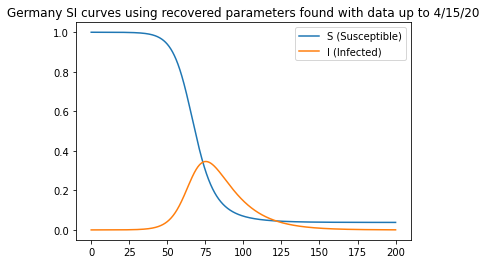

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import time

tf = 200
Nmax = 1000 ## to determine the step h
I0 = 1000/(6.7*10**7)
X0 = [1-I0, I0, 0] ## initial condition

# mu = 0.02541707512339562
# beta = 0.2492569240298655

mu_br = 0.02541707512339562
beta_br = 0.2492569240298655
beta_fr = 0.22439674223646572
mu_fr = 0.06937829779000777
beta_gm = 0.22756489337786034
mu_gm = 0.06689588231834465
beta = beta_gm
mu=mu_gm
Sherd = mu/beta



##ODE : x'(t) = f(x,t)
def F(X,t):
    s,i,r = X
    return np.array([-beta*s*i, beta*s*i-mu*i,mu*i])



#resolution


def sir_Runge(X0,tf,N):
    h = 1/N
    Y = [X0]
    y = X0
    ymoins = X0
    T = [0]
    t = 0
    for k in range(tf*N):
        ymilieu =  y + (h/2)*F(y,t)
        y = y +(h)*F(ymilieu,t + h/2)
        t = t + h
        Y.append(y)
        T.append(t)

    return T,Y



Tmax,Ygood = sir_Runge(X0,tf, Nmax)

S = [y[0] for y in Ygood]
I = [y[1] for y in Ygood]
plt.title('Germany SI curves using recovered parameters found with data up to 4/15/20')
plt.plot(Tmax, S, label='S (Susceptible)')
plt.plot(Tmax, I, label='I (Infected)')
plt.legend()